In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

# Imports all the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix
from umap import UMAP
from tqdm import tqdm

from functools import partial

import jax
from jax import numpy as jnp
import haiku as hk
import optax

import resnet
import data
import train
import pickle

In [2]:
assert jax.local_device_count() >= 8, "TPUs not detected"

In [3]:
NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

jax.config.update("jax_debug_nans", False)
classes = ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral']

rng = jax.random.PRNGKey(SEED)

In [4]:
(x_train, y_train), (x_test, y_test) = data.load_data('.', rng, test_size = 0.1)

x_all = np.concatenate([x_test, x_train])
y_all = np.concatenate([y_test, y_train])

tcmalloc: large alloc 7241465856 bytes == 0x8ab2e000 @  0x7f6afeb5d680 0x7f6afeb7e824 0x7f6af40ef4ce 0x7f6af414500e 0x7f6af4145c4f 0x7f6af41e7924 0x5f2cc9 0x5f30ff 0x5705f6 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956
tcmalloc: large alloc 7241465856 bytes == 0x244746000 @  0x7f6afeb5d680 0x7f6afeb7e824 0x7f6afeb7eb8a 0x7f67e8f17c37 0x7f67e8eca5eb 0x7f67e8edb7a6 0x7f67e8edc6dd 0x7f67e4d45b09 0x7f67e4d491a0 0x7f67e8bf7302 0x7f67e62f2220 0x7f67e62f2910 0x7f67e62cde95 0x7f67e62d4686 0x7f67e62d6434 0x7f67e3ed63bf 0x7f67e3c4f9a8 0x7f67e3c3f540 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369
tcmalloc: large alloc 7241465856 bytes == 0x3f78fe000 @  0x7f6afeb5d680 0x7f6afeb7e824 0x7f6afeb7eb8a 0x7f67e8f17c37 0x7f67e8eca5eb 0x7f67e8edb7a6 0x7f67e8edc6dd 0x7f67e4d45b09 0x7f67e4

In [5]:
def forward(batch, is_training, return_representation = False, return_gradcam = False, gradcam_counterfactual = False):
    net = resnet.ResNet18(num_classes = NUM_CLASSES, resnet_v2 = True)
    if return_representation:
        return net.embedding(batch, is_training, embedding_depth=0)
    elif return_gradcam:
        return net.gradcam(batch, is_training, gradcam_depth=0, counterfactual=gradcam_counterfactual)
    else:
        return net(batch, is_training)

net = hk.transform_with_state(forward)
schedule = optax.cosine_decay_schedule(1e-1, 30 * (len(x_train) // BATCH_SIZE))
optim = optax.adamw(schedule, weight_decay = 1e-3)

In [6]:
# Gets functions for the model
init_fn, loss_fn, grad_fn, update, predict, evaluate, train_epoch = train.get_network_fns(net, optim, BATCH_SIZE)

# Initializes parameters and state
params, state, optim_state = init_fn(rng)

In [7]:
# Train the model for 30 epochs
#for i in range(30):
#    params, state, optim_state = train_epoch(params, state, optim_state, x_train, y_train, x_test, y_test)


def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_model = load_model("checkpoints/checkpoint.npy")
params = loaded_model[0]
state = loaded_model[1]
optim_state = loaded_model[2]

In [8]:
import pickle

def save_model(filename):
    with open(filename, "wb") as f:
        pickle.dump((params, state, optim_state), f)

# save_weights("checkpoint.npy")

In [10]:
gradcam_batch_size = 8
datagen, num_batches = train.get_datagen(True, gradcam_batch_size, x_all, y_all, include_last = False)

# List with all the predictions
cams = []
counter_cams = []
# Applies the network to each batch
for x_batch, y_batch in tqdm(datagen()):
    apply = jax.pmap(net.apply, static_broadcasted_argnums = (2,4,5,6,7))
    cam = apply(params, state, None, x_batch, False, False, True, False)[0]
    counter_cam = apply(params, state, None, x_batch, False, False, True, True)[0]
    cams.append(cam)
    counter_cams.append(counter_cam)

cams = jnp.concatenate(cams)
counter_cams = jnp.concatenate(counter_cams)
cams.shape

1151it [03:19,  5.78it/s]


(9208, 4, 8, 8)

In [11]:
y_predicted = predict(params, state, x_all, training=False)
y_predicted.shape

100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:23<00:00,  3.04it/s]


(9208, 4)

Displaying COVID-19


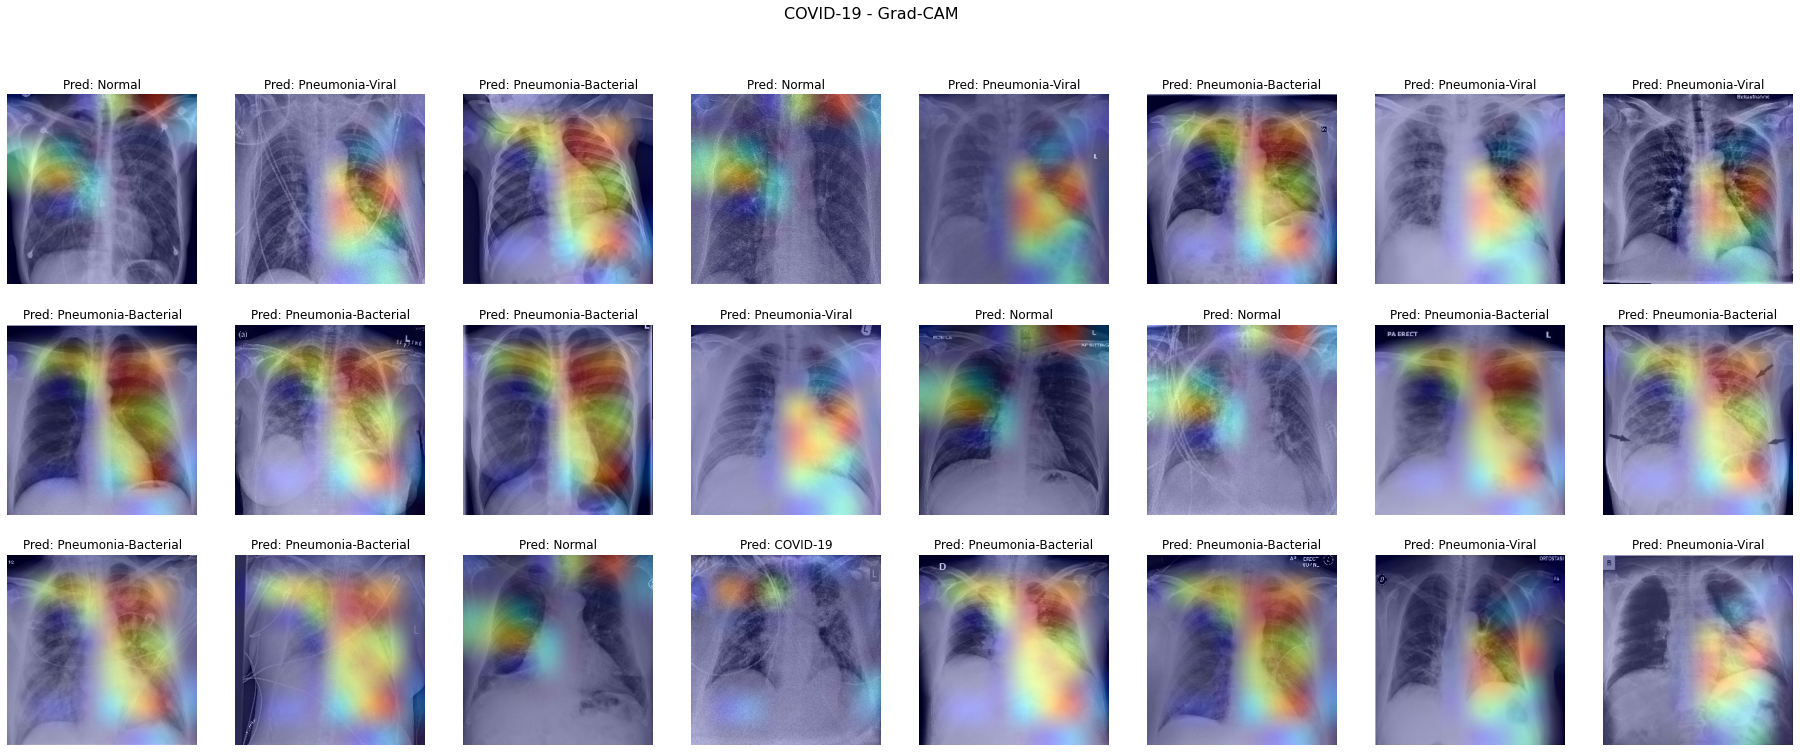

In [21]:
from IPython.display import Image, display
import matplotlib.cm as cm
import cv2
import utils

# TODO: something is wrong with the preview - compute error rates, maybe the wheres are messed up

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap /= heatmap.max()
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_CUBIC)
    jet_heatmap /= jet_heatmap.max()

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img /= superimposed_img.max()

    # Display Grad CAM
    plt.imshow(superimposed_img)

CLASS_TO_DISPLAY = 2
COUNTER_CLASS = 2
COUNTERFACTUAL = False
ROWS = 3
COLUMNS = 8
DISPLAY_RNG = jax.random.PRNGKey(4)

class_indices = jnp.where(y_all > 0)[1]
indices_to_display = jnp.where(class_indices == CLASS_TO_DISPLAY)[0]

predicted_indices = jnp.where(y_predicted > 0)[1]

indices_to_show = jax.random.choice(DISPLAY_RNG, covid_indices.shape[0], shape=[ROWS*COLUMNS])

print("Displaying", utils.CLASS_NAMES[CLASS_TO_DISPLAY])

# create figure
fig = plt.figure(figsize=(32, 12))
fig.suptitle(utils.CLASS_NAMES[CLASS_TO_DISPLAY] + (" - Grad-CAM" if not COUNTERFACTUAL else " - Counterfactual Grad-CAM"), fontsize=16)

for i in range(ROWS*COLUMNS):
    fig.add_subplot(ROWS, COLUMNS, i+1)

    index = indices_to_show[i]
    img_index = indices_to_display[index]
    class_index = class_indices[img_index]
    pred = predicted_indices[img_index]
    img = x_all[img_index,]

    if not COUNTERFACTUAL:
        heatmap = cam[img_index, pred]
    else:
        heatmap = counter_cam[img_index, COUNTER_CLASS]

    display_gradcam(img, heatmap, alpha=0.5)

    title = "Pred: " + utils.CLASS_NAMES[pred]

    plt.title(title)
    plt.axis('off')